In [158]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy

# Přednáška 7: Monte Carlo, particle filtrace

## Motivační příklad

Nejprve malý skoro nematematický příklad, na intuici. Uvažujme, že máme kruh $\mathcal{K}$ o poloměru $r=1$. Víme, že jeho obsah je

$$
\mathcal{S}_{\mathcal{K}} = \pi r^2 = \pi,
$$

a chceme odhadnout hodnotu $\pi$. Vpíšeme tento kruh do čtverce $\mathcal{R}$ o straně $2r = 2$, viz obrázek.

<<< OBR >>>

Budeme-li předpokládat, že na tento obrazec dokonale rovnoměrně prší, jaká je pravděpodobnost, že kapka padne do kruhu? Velmi jednoduše - díky rovnoměrnosti deště - ji lze určit jako poměr plochy kruhu k ploše čtverce,

$$
P[x_i \in \mathcal{K}] 
= \frac{\mathcal{S}_{\mathcal{K}}}{\mathcal{S}_{\mathcal{R}}}
= \frac{\pi r^2}{2r \cdot 2r}
= \frac{\pi}{4}.
$$

Budeme tedy generovat náhodné vzorky z $\mathcal{U}_{[-1,1]\times[-1,1]}$ a zjišťovat, zda leží uvnitř kruhu nebo vně:

In [52]:
def estimate_pi(nsamples):
    samples = np.random.uniform(low=-1, high=1, size=(nsamples, 2))
    samples_dist_from_origin = np.sqrt((samples**2).sum(axis=1))
    samples_in_circle = np.sum(samples_dist_from_origin <= 1)
    probability = samples_in_circle / nsamples
    pi = 4 * probability
    return pi

nsamples = 1000
print('Estimate of pi: {0:.5f}'.format(estimate_pi(nsamples)))

Estimate of pi: 3.17600


## Monte Carlo integrace

Z analýzy víme, že integrál funkce $f(x)$ na intervalu $[a, b]$ je - velmi vágně řečeno - v podstatě součet malých obdélníků s výškou $f(x_i)$ a délkou strany $\Delta x$ (uvažujme shodná $\Delta x$),

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0} \sum_{i=1}^{N} f(x_i) \Delta x.
$$

Protože uvažujeme stejná $\Delta x$, můžeme je vytknout před sumu a rovnoměrně jimi rozdělit interval $[a,b]$ na $N$ podintervalů a vlastně se přesunout ke střední hodnotě funkce,

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0}  \sum_{i=1}^{N} f(x_i) \Delta x
= \frac{b-a}{N}\sum_{i=1}^{N} f(x_i) = V \frac{\sum_{i=1}^{N} f(x_i)}{N} = (b-a) \langle f \rangle,
$$

kde jsme označili střední hodnotu

$$
\langle f \rangle = \frac{\sum_{i=1}^{N} f(x_i)}{N}
$$

a "objem" (angl. volume) množiny $V = b - a$.

### Vícerozměrný případ

Obecně $M$-rozměrný případ je pouze analogií k jednorozměrnému. Pracujeme s integrálem funkce proměnné $x = [x_1, \ldots, x_M]$ a body $x_i = [x_{i,1}, \ldots, x_{i,M}]$,

$$
\int_{a_1}^{b_1} \cdots \int_{a_M}^{b_M} f(x) dx 
\xleftarrow[N\to\infty]{}
\frac{(b_1 - a_1) \cdots (b_M - a_M)}{N_1 \cdots N_M} \sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)
= V \langle f \rangle,
$$

kde $V = (b_1 - a_1) \cdots (b_M - a_M)$ je objem množiny a $\langle f \rangle = \frac{\sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)}{N_1 \cdots N_M}$ je střední hodnota funkce.

## Monte Carlo integrace

Základní ("naivní") Monte Carlo integrace využívá výše vyložený princip s tím, že body $x_i$ nebere jako **deterministicky stanovené body v rovnoměrně rozdělené síti**, ale **vybírá tyto body náhodně z rovnoměrného rozdělení**. Středování (průměrem) i objem množiny zůstávají zachovány. Zákon velkých čísel potom zajišťuje, že pro vzorky $x_i$ kde $i=1,\ldots,N$ nám Monte Carlo odhad integrálu konverguje ke skutečné hodnotě při $N\to \infty$. Konkrétně, pro varianci střední hodnoty funkce platí

$$
\mathrm{Var}(f) = \sigma_N^2 = \frac{1}{N}\sum_{i=1}^N (f(x_i) - \langle f \rangle)^2,
$$

a tedy variance odhadu integrálu

$$
\mathrm{Var}(V \langle f \rangle) = \frac{V^2}{N^2}\sum_{i=1}^N \operatorname{Var}(f) = V^2 \frac{\sigma_N^2}{N}.
$$

Z toho plyne, že pro $N\to\infty$ konverguje $\mathrm{Var}(V \langle f \rangle)$ - a tedy chyba odhadu - k nule.

## Odhad $\pi$ podruhé - integrací

Víme, že plocha jednotkového kruhu je $S = \pi r^2 = \pi$. Protože chceme pracovat s funkcí, bude výhodné uvažovat jen první kvadrant, jehož plocha je $S_{\frac{1}{4}} = \frac{\pi}{4}$. V prvním kvadrantu pro body na jednotkové kružnici tvořící hranici kruhu platí, že $x^2 + y^2 = r^2 = 1$ a tedy $y = \sqrt{r^2 - x^2} = \sqrt{1 - x^2}$. A plocha pod touto funkcí je rovněž 1/4 plochy kruhu. Tedy

$$
S_{\frac{1}{4}} = \frac{\pi}{4} = \int_{0}^{1} \sqrt{1-x^2}dx \qquad\text{z čehož plyne}\qquad
\pi = 4 \int_{0}^{1} \sqrt{1-x^2}dx.
$$

Algoritmus bude následující:
   1. Vygenerujeme N náhodných vzorků $x_i \sim \mathcal{U}(0, 1)$.
   2. Spočteme střední hodnotu integrované funkce přes všechna $x_i$, tedy $\langle f \rangle = \frac{1}{N} \sum_{i=1}^{N} \sqrt{1-x_i^2}$.
   3. Objem $V = 1 \cdot 1 = 1$.
   4. $\pi = 4 \cdot V \langle f \rangle$.

In [89]:
@np.vectorize
def pi_mc_integration(nsamples):
    xi = np.random.uniform(0, 1, size=nsamples)
    fxi = np.sqrt(1 - xi**2)
    mean = np.mean(fxi)
    return 4 * mean

nsamples = np.power(10, range(8))
pi_estimates = pi_mc_integration(nsamples)
print(pi_estimates)

[ 3.92557486  2.99516329  3.1413758   3.13494678  3.12504342  3.1403652
  3.14189274  3.14179331]


## Rejection sampling (accept-reject alg.)

V bayesovské teorii se často setkáváme s komplikovanými aposteriorními distribucemi vyjadřujícími odhad hledané veličiny (parameteru). V dřívějších přednáškách jsme se tomuto jevu elegantně vyhýbali používáním *konjugovaných apriorních distribucí*. Pokud ovšem nechceme nebo nemůžeme konjugované apriorno použít, potřebujeme se stále nějak dopracovat k vlastnostem aposteriorní distribuce, například k její střední hodnotě apod. Pokud se nechceme nebo nemůžeme zaobírat analytickými metodami a aproximacemi, můžeme využít Monte Carlo vzorkování, z aposteriorna nagenerovat hromadu vzorků a spočítat z nich jeho přibližné vlastnosti. 

Jednou z nejjednodušších metod je tzv. **rejection sampling**, známý též jako accept-reject algoritmus. Ten využívá tzv. proposal distribuci (český ekvivalent?), což je nějaká vhodná distribuce, z níž umíme snadno vzorkovat (nebo na to máme vhodný software). 

Označme $f(x)$ hustotu, z níž chceme vzorkovat. Algoritmus je postaven na tom, že

$$
f(x) = \int_0^{f(x)} du = \int_0^1 \underbrace{\mathbb{1}_{0<u<f(x)}}_{f(x,u)}du.
$$

Vidíme, že na $f$ je možné nahlížet jako na marginálníá hustotu sdružené distribuce

$$
(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}.
$$

> **Základní teorém vzorkování (Fundamental theorem of simulation)**: Vzorkování $x\sim f(x)$ je ekvivalentní k vzorkování $(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}$.

Tento teorém nejde využít přímo, ale je možné jít oklikou: Navzorkovat $(x, u)$ z větší množíny a vybrat takové dvojice, pro něž je podmínka $0 < u < f(x)$ splněna.

### Algoritmus
Předpokládejme, že $\int_a^b f(x)dx = 1$ a zvolme $m > f(x)$ pro všechna $x\in[a,b]$. Vzorkujeme $(x', u) \sim \mathcal{U}(0<u<m)$ tak, že:
   1. Navzorkujeme $x' \sim \mathcal{U}(a, b)$,
   2. navzorkujeme $u|x=x' \sim \mathcal{U}(0, m)$,
   3. vzorek přijmeme, pokud $0<u<f(x')$.

### Příklad

V následujícím příkladu budeme generovat vzorky z N(0, 1) na intervalu [-2, 2]. Vykreslíme si histogram a vzorky.

% acceptance:  77.4266666667


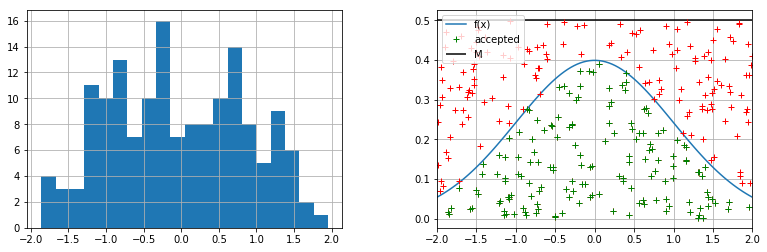

In [199]:
nsamples = 300     ### Number of samples
M = .5             ### M

samples_u = np.random.uniform(low=0., high=M, size=nsamples)   # uniform samples
samples_x = np.random.uniform(-2, 2, size=nsamples)            # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
accepted = np.where(samples_u < fx)[0]

print("% acceptance: ", accepted.sum()/nsamples)
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-2, 2, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_x, samples_u, 'r+')
plt.plot(samples_x[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(-2, 2)
plt.legend()
plt.show()

Výše uvedený algoritmus je pěkný, ale šel by výrazně vylepšit. Vzorkovat totiž můžeme rovnou přes množinu

$$
\mathcal{L} = \{(x', u): 0 < u < m(x')\}\qquad\text{kde}\qquad m(x) \geq f(x).
$$

Funkce $m(x)$ zjevně není hustotou (proč?). Můžeme ale využít nějaký vhodný **proposal** $g(x)$, který hustotou bude, a vhodné kladné číslo $M>0$ a nastavit

$$
m(x) = M g(x).
$$

### Algoritmus
   1. Navzorkujeme $x' \sim g$,
   2. navzorkujeme $u \sim \mathcal{U}(0, 1)$,
   3. vzorek $x'$ přijmeme, pokud $u\leq \frac{f(x')}{Mg(x')}$.

### Příklad

V následujícím příkladě budeme generovat vzorky z normálního rozdělení N(0, 1) pomocí Cauchyho proposalu. Histogram by měl odpovídat realizacím z normálního rozdělení.

% acceptance:  89.16


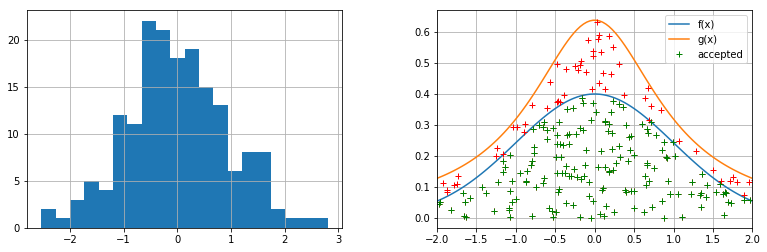

In [200]:
nsamples = 300     ### Number of samples
M = 2              ### M

samples_u = np.random.uniform(low=0., high=1., size=nsamples)  # uniform samples
samples_x = cauchy.rvs(size=nsamples)                          # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
ratio = fx / (M * cauchy.pdf(samples_x))
accepted = np.where(samples_u < ratio)[0]

print("% acceptance: ", accepted.sum()/nsamples)

plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-2, 2, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.plot(x, M*cauchy.pdf(x), '-', label='g(x)')
plt.plot(samples_x, M*cauchy.pdf(samples_x)*samples_u, 'r+')
plt.plot(samples_x[accepted], M*cauchy.pdf(samples_x[accepted])*samples_u[accepted], 'g+', label='accepted')
plt.xlim(-2, 2)
plt.legend()
plt.show()

Lze snadno ukázat, že pravděpodobnost přijetí vzorku je $1/M$, proto čím blíže je $M$ k vzorkované hustotě, tím vyšší četnost přijatých vzorků.

Rejection sampling je mnohem efektivnější, než "naivní" výše vyložené Monte Carlo. Má ale také své nedostatky, např. s efektivitou v oblastech, kde je hustota koncentrována na malou podmnožinu, nebo naopak tam, kde nabývá velmi nízkých hodnot a většina vzorků není přijata.

## Importance sampling

Rejection sampling "kompenzuje" fakt, že ke vzorkování používá jinou hustotu, prostřednictvím **přijímání či zahazování** vzorků, což může být vnímáno jako ústupek na efektivitě. Alternativní metoda - **importance sampling** - tento fakt kompenzuje přidělováním **vah** všem vzorkům. Označíme-li opět $f(x)$ naši cílovou (komplikovanou) hustotu a $g(x)$ proposal hustotu, zcela přímočaře vidíme, že

$$
\int f(x) dx = \int g(x) \underbrace{\frac{f(x)}{g(x)}}_{= w(x)} dx = \int g(x) w(x) dx.
$$

Podmínkou je, že $g(x) > 0$ všude, kde je $f(x) > 0$.
To můžeme navíc pěkně zobecnit, např. pro střední hodnotu funkce $h(x)$ při $f(x)$ platí

$$
\mathbb{E}_f[h(x)] = \int h(x) f(x) dx =  \int h(x) \frac{f(x)}{g(x)}g(x) dx = \int h(x) w(x) g(x) dx = \mathbb{E}_g[w(x)h(x)], \qquad g(x) > 0.
$$

Podmínkou je, že $g(x) > 0$ všude, kde je $h(x)f(x) \ne 0$.

Pro náhodné realizace (vzorky) $x_1, \ldots, x_N \sim g$ potom platí, že s $N\to\infty$

$$
\begin{aligned}
\frac{1}{N} \sum_{i=1}^N w(x_i)h(x_i) 
&\to \mathbb{E}_g[w(x)h(x)] \\
&\to \mathbb{E}_f[h(x)].
\end{aligned}
$$

Jinými slovy, odhad střední hodnoty dostaneme jako vážený průměr vzorků,
$$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^N w(x_i)h(x_i).
$$

Je zřejmé, že takto definované váhy $w(x_i)$ nemusí dávat součet 1, proto se většinou z praktických důvodů používá normovaná varianta vah,
$$
W(x_i) = \frac{w(x_i)}{\sum_{i=1}^{N} w(x_i)}.
$$

a odhad střední hodnoty potom je

$$
\hat{\mu} = \sum_{i=1}^N W(x_i)h(x_i).
$$

Lze ukázat, že tento odhad je sice vychýlený, ale může mít nižší varianci. V bayesovství má ještě jednu výhodu - nezávisí na normalizační konstantě, jejímuž výpočtu se s oblibou vyhýbáme :-)


### Algoritmus IS

Celý algoritmus je o určování vah, které pak používáme např. při výpočtu integrálů.

   1. Nagenerujeme $N$ vzorků z proposal hustoty: $x_i \sim g(x)$.
   2. Spočteme hodnotu hustoty $f(x_i)$.
   3. Spočteme hodnotu hustoty $g(x_i)$.
   4. Spočteme váhy $w(x_i) = \frac{f(x_i)}{g(x_i)}$.
   5. Váhy normalizujeme, buď $W(x_i) = w(x_i)/\sum w(x_i)$ nebo $W(x_i)=w(x_i)/N$.
   
Např. odhad střední hodnoty $\hat{\mu} = \sum w(x_i) x_i$.

### Příklad

Následující příklad demonstruje integraci přes IS, konkrétně odhad střední hodnoty Studentova $t_3$ rozdělení posunutého do jedničky.

Estimated mean with N:  0.696351519353
Estimated mean with normalized w:  0.816349671756


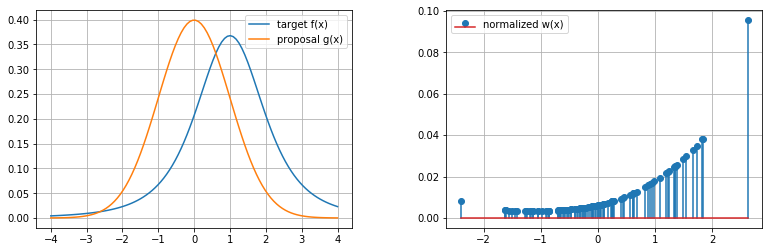

In [203]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm, uniform, t

nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

# Target - t distribution
def target_pdf(x):
    return t.pdf(x, df=3, loc=1)

samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)

fx = target_pdf(samples_x)
gx = norm.pdf(samples_x, loc=proposal_loc, scale=proposal_std)

weights = fx/gx
weights_normalized = weights/weights.sum()

mean = np.mean(samples_x * weights)
mean_normalized = np.sum(samples_x * weights_normalized)
print('Estimated mean with N: ', mean)
print('Estimated mean with normalized w: ', mean_normalized)

plt.figure(figsize=(13,4))
plt.subplot(121)
x = np.linspace(-4, 4, 100)
plt.plot(x, target_pdf(x), label='target f(x)')
plt.plot(x, norm.pdf(x, loc=proposal_loc, scale=proposal_std), label='proposal g(x)')
plt.legend()
plt.subplot(122)
plt.stem(samples_x, weights_normalized, label='normalized w(x)')
plt.legend()
plt.show()

### Empirická distribuce

Pokud máme vzorky (realizace) $\{x_i\}_{i=1}^N = \{x_1, \ldots, x_N\}$ na množině $E$, můžeme mluvit o empirické distribuci ve tvaru

$$
\eta^N(x) = \frac{1}{N} \sum_{i=1}^N \delta_{x_i}(x).
$$

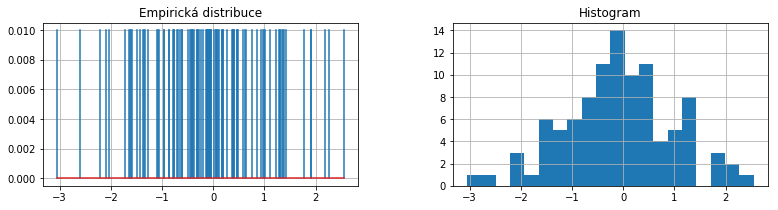

In [215]:
x = np.random.normal(size=100)
plt.figure(figsize=(13,3))
plt.subplot(121)
plt.title('Empirická distribuce')
plt.stem(x, np.ones_like(x)/x.size, markerfmt=' ')
plt.subplot(122)
plt.title('Histogram')
plt.hist(x, bins=20)
plt.show()

Pokud jsou k $x_i$ přiřazeny váhy (např. z importance samplingu), tj. máme dvojice $\{x_i, w_i\}_{i=1}^N$, můžeme mluvit o empirické distribuci ve tvaru

$$
\tilde{\eta}^N(x) = \frac{\sum_{i=1}^N w_i \delta_{x_i}(x)}{\sum_{i=1}^N w_i},
$$

přičemž můžeme normalizaci (viz jmenovatel) provést rovnou,

$$
W_i = \frac{w_i}{\sum_{i=1}^N w_i}
$$

podobně jako v importance samplingu výše. Pak lze pro funkci $h(x)$ psát např.

$$
\int h(x)g(x)dx \approx \int h(x) g^N(x) dx,
$$

kde $g^N(x)$ je empirická distribuce ze vzorků $x_i \sim g(x)$.

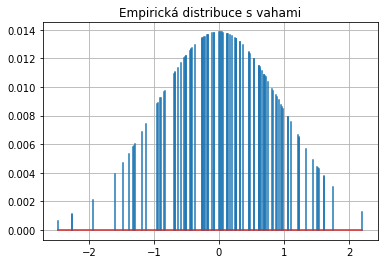

In [218]:
x = norm.rvs(size=100)
wx = norm.pdf(x)
wx /= wx.sum()
plt.stem(x, wx, markerfmt=' ')
plt.title('Empirická distribuce s vahami')
plt.show()

## Sequential Importance Sampling (SIS)

Pro pozdější potřeby se podívejme, jak se dá rozepsat  vývoj vah $w_i$ pokud budeme **sekvenčně** přidávat veličiny $x_1, x_2$ atd.

$$
\begin{aligned}
\int h(x_1, x_2) \pi(x_1, x_2) dx_1 dx_2
&= \int h(x_1, x_2) \frac{\pi(x_1, x_2)}{q(x_1, x_2)} q(x_1, x_2) dx_1 dx_2 \\
&= \int h(x_1, x_2) \frac{\pi(x_1, x_2)}{q(x_2|x_1) q(x_1)} q(x_1)q(x_2|x_1) dx_1 dx_2 \\
&= \int h(x_1, x_2) \underbrace{\frac{\pi(x_1, x_2)}{q(x_2|x_1) \pi(x_1)}}_{\widetilde{w}_2} \underbrace{\frac{\pi(x_1)}{q(x_1)}}_{w_1} q(x_1)q(x_2|x_1) dx_1 dx_2. \\
\end{aligned}
$$

Jak je patrné, lze odstartovat z $x_1$ s vahou $w_1$, následně získat $x_2$ podle nějaké hustoty - modelu - $q(x_2|x_1)$ a jen updatovat váhu přenásobením inkrementem $\widetilde{w}_2$. To je velmi užitečné zjištění, neboť s počátečními vzorky postačí jen využívat model a updatovat váhy.

Vraťme se nyní k problematice stavových modelů ve tvaru

$$
\begin{aligned}
x_t &\sim f_t(x_t|x_{t-1}), \\
y_t &\sim g_t(y_t|x_t),
\end{aligned}
$$

kde $x_t$ je nepozorovatelný stav systému, $f_t(x_t|x_{t-1})$ je model vývoje v podobě nějaké vhodné hustoty pravděpodobnosti, $y_t$ jsou pozorování (též měření) a $g_t(y_t|x_t)$ je model pozorování, rovněž v podobě nějaké vhodné hustoty. Pokud oba modely jsou lineární a příslušné funkce jsou hustoty normálního rozdělení, víme z dřívějších přednášek, že sekvenční odhad pro $t=1, 2, \ldots$ poskytne např. Kalmanův filtr. A když linerita splněna není, můžeme zkusit rozšířený Kalmanův filtr. A pokud je nelinerita silná, je velmi vhodné využít právě **importance sampling** v jeho sekvenční podobě naznačené výše.

Stejně jako v případě Kalmanova filtru (a všech bayesovských odhadů) začneme od vhodně zvolené apriorní hustoty, kterou zde ale **navzorkujeme** do podoby empirické distribuce reprezentované vzorky $\{x_{1:t-1}^{(i)}, w_{t-1}^{(i)}\}_{i=1}^N$,

$$
\pi(x_{1:t-1}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t-1}^{(i)}}(x_{1:t-1}).
$$

Stejně jako v případě základního Kalmanova filtru poběží základní SIS filtr ve dvou krocích - predikce a update.

### Predikce
Predikce udává časový vývoj stavů z $x_{t-1}$ na $x_t$ podle příslušného modelu. Použijeme tedy apriorní distribuci a přenásobíme ji modelem,

$$
\pi(x_{1:t}|y_{1:t-1}) = \pi(x_{1:t-1}|y_{1:t-1}) \cdot f_t(x_t|x_{t-1}).
$$

V SIS filtru to znamená, že vzorky "proženeme" modelem v podobě samplování z modelu, do něhož vložíme vzorky předchozí,

$$
x_t^{(i)} \sim f_t(x_t|x_{t-1}^{(i)}).
$$

Tím dostaneme novou empirickou distribuci

$$
\pi(x_{1:t}|y_{1:t-1}) = \sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}).
$$

### Update
Update využije Bayesovu větu - vloží do hustoty stavů nová pozorování (měření). Aplikuje ji na empirickou distribuci z predikce,

$$
\begin{aligned}
\pi(x_{1:t}|y_{1:t})
&\propto \pi(x_{1:t}|y_{1:t-1}) \cdot g_t(y_t|x_t) \\
&\approx \frac{\sum_{i=1}^N w_{t-1}^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}) \cdot g(y_t|x_t^{(i)})}{\sum_{i=1}^N w_{t-1}^{(i)}(x_{1:t}) \cdot g(y_t|x_t^{(i)})} \\
&\propto \sum_{i=1}^N w_t^{(i)} \delta_{x_{1:t}^{(i)}}(x_{1:t}).
\end{aligned}
$$

Tedy

$$
w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})
$$

následované normalizací
$$
w_t^{(i)} \leftarrow \frac{w_t^{(i)}}{\sum_{j=1}^N w_t^{(j)}}.
$$

### Algoritmus SIS filtru
   1. Navzorkujeme $x_0^{(i)}$ z vhodné apriorní distribuce $\pi(x_0)$ a přiřadíme jim rovnoměrné váhy $w_0^{(i)} = 1/N$.
   2. Pro $t=1,2,\ldots$:
       - Predikce: navzorkujeme nová $x_t^{(i)}$ z hustoty $f_t(x_t|x_t^{(i)})$.
       - Update: přepočítáme váhy $w_t^{(i)} = w_{t-1}^{(i)} g(y_t|x_t^{(i)})$ a normalizujeme je $w_t^{(i)} \leftarrow w_t^{(i)}/\sum_j w_t^{(j)}$.
       - Odhad střední hodnoty $\mathbb{E}[x_t|\cdot] = w_{t}^{(i)} x_t^{(i)}$.

### Příklad

Uvažujme pro jednoduchost lineární model

$$
\begin{align}
x_t &= 0.9 x_{t-1} + 0.7 + w_t \\
y_t &= 0.5 x_t + v_t
\end{align}
$$

kde $x_1$ = 1 a

$$
w_t \sim \mathcal{N}(0, 0.2^2), \qquad v_t \sim \mathcal{N}(0, 0.2^2).
$$

Jako proposal distribuci použijeme $\mathcal{N}(0, 1)$.

Velmi jednoduchý nepříliš optimální kód může vypadat takto:

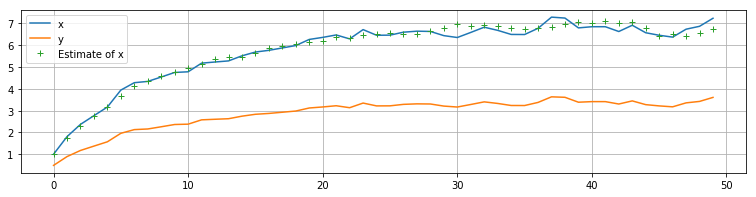

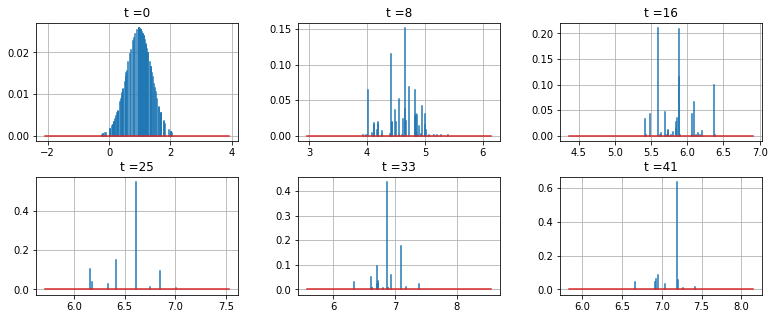

In [206]:
nsamples = 100    ### Number of samples
proposal_loc = 0  ### Mean of normal proposal
proposal_std = 1  ### St. deviation of normal proposal

ndat = 50         ### number of observations
xstd = .2         ### noise std on x
ystd = .2         ### noise std on y

def prediction(xold):
    loc = .9 * xold + .7
    xnew = norm.rvs(loc=loc, scale=xstd)
    return xnew

def update(y, x, weights):
    loc = .5 * x
    weights *= norm.pdf(y, loc=loc, scale=ystd)
    weights /= weights.sum()
    return weights

x = np.zeros(ndat)
x[0] = 1
y = np.zeros(ndat)

# Data simulation
for t in range(1, ndat):
    x[t] = .9 * x[t-1] + .7
    x[t] += norm.rvs(scale=xstd)
y = .5 * x + norm.rvs(scale=ystd)

# Filter initialization
samples_x = norm.rvs(loc=proposal_loc, scale=proposal_std, size=nsamples)
weights = np.ones(nsamples)/nsamples

# Logs
est_log = np.zeros(ndat)
weights_log = np.zeros((ndat, nsamples))
samples_log = np.zeros((ndat, nsamples))
for t, yt in enumerate(y):
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights)
    est_log[t] = estimate
    weights_log[t] = weights.copy()
    samples_log[t] = samples_x.copy()

plt.figure(figsize=(13, 3))
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.plot(est_log, '+', label='Estimate of x')
plt.legend()

plt.figure(figsize=(13, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    row = i * ndat // 6
    plt.stem(samples_log[row], weights_log[row], markerfmt=' ')
    plt.title('t ={0}'.format(row))

V obrázcích výše vidíme několik zajímavostí. Jednak vývoj stavu $x_t$, jeho odhadu a vývoj pozorování $y_t$. Na 6 malých obrázcích potom vývoj vah pro různé vzorky. Připomeňme, že vzorků je `nsamples`, ale váhy se postupně zkoncentrují na několika málo vzorcích. A co hůř, postupně by celý filtr s rostoucím $t$ zdegeneroval do jediného vzorku! Jak se tento problém řeší se dozvíme u SIR filtru.

Co by šlo dále vylepšit? Předně, výpočet vah jak je uveden výše není numericky stabilní - inkrementální váhy jsou totiž velmi blízké nule a hrozí, že na numerice se po násobení projeví právě tou nulou. To se elegantně řeší počítáním v logaritmech.